##### DATA ANALYSIS TEXTBOOK
##### Chapter 13 Prediction
#
##### Used car data for LA and Chicago

##### graphs not in textbook!
##### WHAT THIS CODES DOES:
##### prep - cleans the data, makes it ready for work
##### Models
##### Measure of fits
##### Cross validation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch13-used-cars-reg/"
output = dirname + "da_case_studies/ch13-used-cars-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")

In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [6]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

In [7]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [8]:
# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

In [9]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [10]:
# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

In [11]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [12]:
data = data.query("~(transmission=='manual')")

In [13]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [14]:
# drop if truck
data = data.query("~(type=='truck')")
# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [15]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3
data.to_csv(data_out + "usedcars_work.csv", index=False)

In [16]:
df = pd.read_csv(data_out + "usedcars_work.csv")

# Frequency tables

In [17]:
# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
area,,
chicago,281,6060.975089
los angeles,197,5518.253807


In [18]:
# focus only on Chicago
data = data.query("area=='chicago'")

In [19]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,67,3988.179104
like new,15,7455.200000


In [20]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,169,6893.485207
rwd,2,6250.000000


In [21]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
dealer,,
0,193,4402.181347
1,88,9699.011364


In [22]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()

,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.298932,12.521702,0.192171,0.071174,0.064057,0.053381,0.266904,0.238434,0.145907
std,5.892153,5.172572,0.394710,0.257575,0.245291,0.225193,0.443131,0.426886,0.353643
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,8.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.655900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,16.430000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,25.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
#Histograms not in the textbook

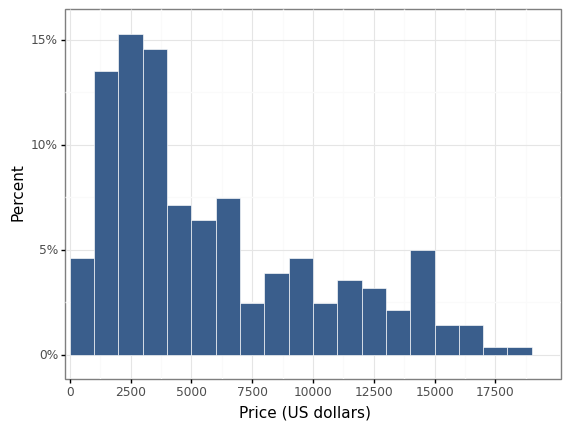

<ggplot: (8752859135796)>

In [24]:
ggplot(data, aes(x="price")) + geom_histogram(
    aes(y="(stat(count))/sum(stat(count))"),
    binwidth=1000,
    boundary=0,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + coord_cartesian(xlim=(0, 20000)) + labs(
    x="Price (US dollars)", y="Percent"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), labels=percent_format()
) + scale_x_continuous(
    expand=(0.01, 0.01), breaks=seq(0, 20000, 2500)
)


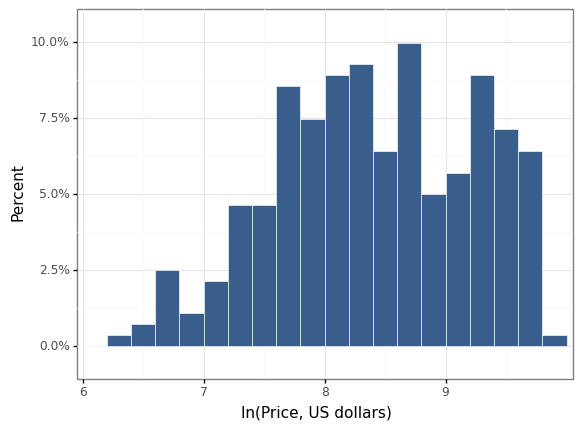

<ggplot: (8752851813298)>

In [25]:
ggplot(data, aes(x="lnprice")) + geom_histogram(
    aes(y="(stat(count)) / sum(stat(count))"),
    binwidth=0.2,
    boundary=0,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + coord_cartesian(xlim=(6, 10)) + labs(
    x="ln(Price, US dollars)", y="Percent"
) + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), labels=percent_format()
) + scale_x_continuous(
    expand=(0.01, 0.01), breaks=seq(6, 10, 1)
) + theme_bw()

### Regression analysis

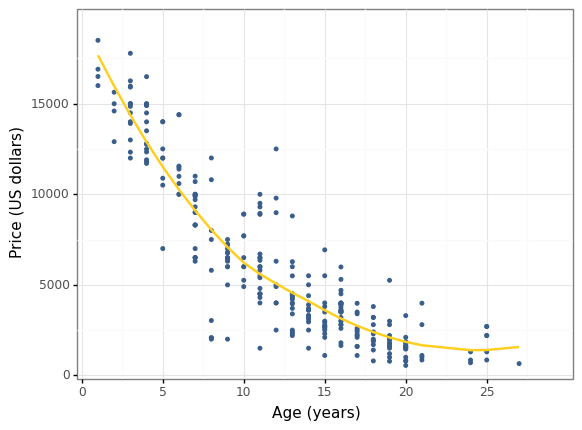

<ggplot: (8752849253958)>

In [26]:
#lowess
ggplot(data, aes(x="age", y="price")) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, colour=color[3], size=1, span=0.9) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 5000)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5)
)


In [27]:
###################################
# Linear regressions

# Model 1: Linear regression on age
reg1=smf.ols("price~age+agesq",data=data).fit(cov_type="HC0")
reg2=smf.ols("price~age+agesq+odometer",data=data).fit(cov_type="HC0")
reg3=smf.ols("price~age+agesq+ odometer + odometersq + LE + cond_excellent + cond_good + dealer",data=data).fit(cov_type="HC0")
reg4=smf.ols("price~age+agesq+ odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",data=data).fit(cov_type="HC0")
reg5=smf.ols("price~age+agesq + odometer + odometersq + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age",data=data).fit(cov_type="HC0")

In [28]:
from sklearn.metrics import mean_squared_error
models = [reg1, reg2,reg3, reg4, reg5]
AIC=[None]*len(models)
BIC=[None]*len(models)
RMSE=[None]*len(models)
Rsquared=[None]*len(models)
regr=[None]*len(models)
k=[None]*len(models)

for i in range(0,len(models)):
    AIC[i]=models[i].aic
    BIC[i]=models[i].bic
    RMSE[i]=np.sqrt(models[i].mse_total)
    Rsquared[i]=models[i].rsquared
    #regr[i]
    k[i]=(models[i].df_model)+1

In [29]:
stargazer.Stargazer([reg1])

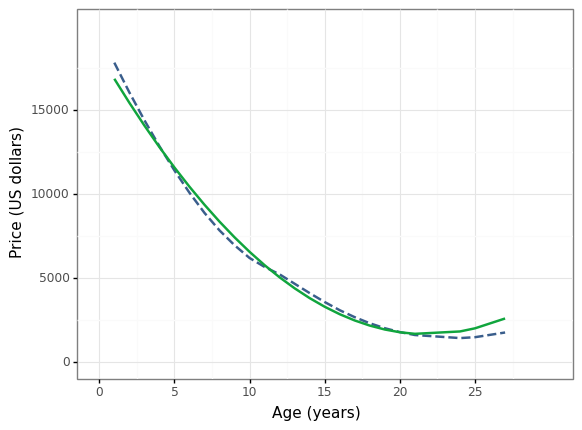

<ggplot: (8752849185253)>

In [30]:
ggplot(data, aes(x="age")) + geom_smooth(
    aes(y="price"),colour=color[0],linetype="dashed", method="loess", se=False, size=1
) + geom_line(aes(y="reg1.predict()"), colour=color[1], size=1) + labs(
    x="Age (years)", y="Price (US dollars)"
) + scale_color_manual(
    name="", values=(color[0], color[1]), labels=("Lowess in age", "Quadratic in age")
) + theme_bw() + scale_x_continuous(
    limits=(0, 30), breaks=seq(0, 30, 5)
) + scale_y_continuous(
    limits=(0, 20000), breaks=seq(0, 20000, 5000)
) + theme(
    legend_position=(20, 20),
    legend_direction="horizontal",
    legend_background=element_blank(),
    legend_box_background=element_rect(color="white"),
)

In [31]:
stargazer.Stargazer([reg1,reg2,reg3,reg4])

## Cross validation

In [32]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=1)


In [33]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [34]:
cv1 = cv_reg("price~age+agesq", data, k, "HC0")
cv2 = cv_reg("price~age+agesq+odometer", data, k, "HC0")
cv3 = cv_reg(
    "price~age+agesq+ odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    data,
    k,
    "HC0",
)
cv4 = cv_reg(
    "price~age+agesq+ odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    data,
    k,
    "HC0",
)
cv5 = cv_reg(
    "price~age+agesq + odometer + odometersq + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age",
    data,
    k,
    "HC0",
)
cv_list = [cv1, cv2, cv3, cv4, cv5]

In [35]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4,Model5
Fold1,1618.115827,1366.548420,1279.793886,1215.424879,1185.937003
Fold2,1811.811621,1449.936044,1337.596555,1274.322122,1242.048531
Fold3,1712.024549,1413.394587,1287.515104,1249.015589,1204.769120
Fold4,1826.251023,1450.552039,1299.776642,1257.653552,1201.181584
Average,1742.050755,1420.107772,1301.170547,1249.104036,1208.484060


### Prediction

In [36]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6"
    ],
]

In [37]:
data.head()

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
2,3,9,3.572100,45.579633,0,0,0,0,1,0,1,14850,0
3,2,4,1.315200,2.274969,0,0,0,0,0,0,1,15630,0
4,25,625,18.700000,6539.203000,0,0,0,0,0,1,0,850,1
6,20,400,16.824259,4762.202089,0,1,0,0,0,0,0,1600,0
7,20,400,16.824259,4762.202089,0,0,0,0,0,0,0,1500,0


In [38]:
new = pd.DataFrame(pd.Series({
    "age":10,
    "agesq":10**2,
    "odometer":12,
    "odometersq":12**2,
    "SE":0,
    "LE":1,
    "XLE":0,
    "cond_likenew":0,
    "cond_excellent":1,
    "cond_good":0,
    "dealer":0,
    "price":np.nan,
    "cylind6":0
})).T
new

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [39]:
#turning off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [40]:
reg1.resid.describe()

count     281.000
mean        0.000
std      1758.313
min     -6367.827
25%      -863.663
50%      -101.332
75%       893.620
max      7448.668
dtype: float64

In [41]:
p1=reg1.get_prediction(new).summary_frame()
p1

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6569.387,155.912,6263.805,6874.968,3097.309,10041.464


In [42]:
(reg3.fittedvalues-data.price).describe()

count     281.000
mean       -0.000
std      1321.029
min     -5818.190
25%      -563.593
50%        19.039
75%       641.749
max      4225.474
dtype: float64

In [43]:
p2=reg3.get_prediction(new).summary_frame()
p2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,5359.323,282.523,4805.588,5913.058,2674.627,8044.019


In [44]:
#get model3 rmse
rmse(reg3.fittedvalues,data.price)

1318.6765443786567

In [45]:
pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,6569.387,5359.323
PI_low(95%),3097.309,2674.627
PI_high(95%),10041.464,8044.019


In [46]:
# summary of predictions and PI 80% version
p1=reg1.get_prediction(new).summary_frame(alpha=0.2)
p2=reg3.get_prediction(new).summary_frame(alpha=0.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,6569.387,5359.323
PI_low(95%),4299.117,3603.894
PI_high(95%),8839.656,7114.751
